## Importing required libraries

* sklearn.metrics (mean_absolute_error): To evaluate model accuracy and quantify forecasting error for implied volatility predictions.

* scipy.stats (pearsonr): To measure the linear correlation between actual and predicted volatility, assessing model performance.

* xgboost (xgb): A gradient boosting framework to train machine learning models on tabular features derived from market data. Useful for capturing non-linear patterns.

* shap: For explainable AI, providing insights into feature importance and model interpretability.

* statsmodels.tsa.arima.model (ARIMA): To perform time-series forecasting, capturing temporal dependencies in implied volatility.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import xgboost as xgb
import shap
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

## Load ETH train and test data

In [13]:
eth_train = pd.read_csv('/kaggle/input/gqimpliedvolatility/train/ETH.csv', parse_dates=['timestamp'])
eth_test = pd.read_csv('/kaggle/input/gqimpliedvolatility/test/ETH.csv')

print("Train shape:", eth_train.shape)
print("Test shape:", eth_test.shape)

Train shape: (631292, 23)
Test shape: (270548, 22)


In [14]:
eth_train.head()

,timestamp,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,...,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,label
0,2024-09-25 18:13:28,2581.605,2581.60,2980.3,2581.59,44.8,2581.56,139.1,2581.54,86.3,...,339.0,2581.67,9.2,2581.69,0.2,2581.70,23.4,2581.71,1.2,0.000060
1,2024-09-25 18:13:29,2581.285,2581.28,1400.6,2581.22,7.8,2581.19,5.0,2581.18,67.1,...,807.2,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,67.1,0.000057
2,2024-09-25 18:13:30,2581.285,2581.28,875.2,2581.22,7.8,2581.20,64.2,2581.19,5.0,...,807.5,2581.30,144.4,2581.31,32.0,2581.32,151.0,2581.33,52.0,0.000080
3,2024-09-25 18:13:31,2581.105,2581.10,1980.0,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,833.3,2581.15,171.1,2581.20,60.7,2581.29,123.5,2581.30,104.0,0.000087
4,2024-09-25 18:13:32,2581.105,2581.10,1995.5,2581.09,508.4,2581.08,0.2,2581.05,18.7,...,717.3,2581.15,132.0,2581.20,60.7,2581.29,69.2,2581.30,242.9,0.000090


In [15]:
eth_test.head()

,timestamp,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,...,ask_price1,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5
0,1,2388.005,2388.0,433.6,2387.99,81.4,2387.96,10.8,2387.94,6.5,...,2388.01,313.0,2388.02,1.3,2388.07,0.1,2388.10,0.2,2388.11,14.9
1,2,2388.005,2388.0,241.0,2387.99,81.4,2387.98,0.6,2387.94,6.5,...,2388.01,316.7,2388.02,14.3,2388.07,0.1,2388.10,24.0,2388.12,155.4
2,3,2387.605,2387.6,22.6,2387.59,4.0,2387.57,0.4,2387.55,10.0,...,2387.61,1816.5,2387.62,13.0,2387.64,104.2,2387.65,20.3,2387.66,0.6
3,4,2387.405,2387.4,246.0,2387.39,0.2,2387.36,62.9,2387.35,15.0,...,2387.41,769.7,2387.46,73.8,2387.47,208.0,2387.50,0.2,2387.52,38.4
4,5,2387.005,2387.0,388.1,2386.99,30.0,2386.97,0.1,2386.96,0.4,...,2387.01,318.1,2387.02,1.3,2387.09,16.6,2387.10,25.5,2387.13,49.2


In [16]:
train_start = eth_train['timestamp'].min()
test_length = len(eth_test)

# Generate 1-second spaced timestamps for test set
eth_test['timestamp'] = pd.date_range(start=train_start + pd.Timedelta(seconds=len(eth_train)), periods=test_length, freq='S')

In [17]:
print(eth_test['timestamp'].head(10))
print(eth_test['timestamp'].dtype)

0   2024-10-03 01:35:00
1   2024-10-03 01:35:01
2   2024-10-03 01:35:02
3   2024-10-03 01:35:03
4   2024-10-03 01:35:04
5   2024-10-03 01:35:05
6   2024-10-03 01:35:06
7   2024-10-03 01:35:07
8   2024-10-03 01:35:08
9   2024-10-03 01:35:09
Name: timestamp, dtype: datetime64[ns]
datetime64[ns]


## Feature Engineering

* spread: Difference between the best ask and best bid prices. Measures market liquidity and transaction cost at a given time.

* depth_imbalance: Captures the relative dominance of buy vs. sell orders by comparing top-level bid and ask volumes. Values near +1 indicate strong buying pressure; values near -1 indicate strong selling pressure.

* log_return: Logarithmic return of the mid-price, used for computing volatility and normalizing price changes.

* realized_vol_30s: Rolling standard deviation of 1-second log returns over a 30-second window. Provides a short-term estimate of actual market volatility, which is useful as a predictive feature for implied volatility forecasting.

Purpose: the engineered features provide both microstructure insights (spread, depth imbalance) and price dynamics (log returns, realized volatility) from high-frequency Ethereum market data. They serve as inputs to both statistical (ARIMA) and machine learning (XGBoost) models for forecasting short-term implied volatility

In [18]:
import numpy as np

def engineer_features(df):
    df['spread'] = df['ask_price1'] - df['bid_price1']
    df['depth_imbalance'] = (
        (df['bid_volume1'] + df['bid_volume2']) -
        (df['ask_volume1'] + df['ask_volume2'])
    ) / (
        (df['bid_volume1'] + df['bid_volume2'] + df['ask_volume1'] + df['ask_volume2']) + 1e-9
    )

    df['log_return'] = np.log(df['mid_price']).diff().fillna(0)
    # Realized volatility over 30s window using 1s log returns
    df['realized_vol_30s'] = df['log_return'].rolling(window=30).std().fillna(0)

    return df

eth_train = engineer_features(eth_train)
eth_test = engineer_features(eth_test)
eth_train.dropna(inplace=True)


## Define features and prepare datasets

* spread -> liquidity/transaction cost indicator
* depth_imbalance -> buy vs sell pressure
* log_return -> normalized price changes
* realized_vol_30s -> short-term realized volatility
* X_train -> training feature matrix extracted from eth_train
* y_train -> target variable - implied volatility label - corresponding to X_train

In [19]:
features = ['spread', 'depth_imbalance', 'log_return', 'realized_vol_30s']


X_train = eth_train[features]
y_train = eth_train['label']

X_test = eth_test[features]
timestamps_test = eth_test['timestamp']


In [20]:
import numpy as np

# Replace inf/-inf with NaN, then fill or drop
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = y_train.fillna(0)

## Train XGBoost and Predict

Data preparation:

* Converting feature matrices (X_train, X_test) to float32 for efficient computation.
* Filling missing values with 0 to prevent errors during training or prediction.
* Ensuring the target variable (y_train) has no NaNs.

Model setup (XGBRegressor):
* n_estimators=200 → Number of boosting rounds.
* learning_rate=0.05 → Step size shrinkage to prevent overfitting.
* max_depth=5 → Maximum depth of each decision tree.
* random_state=42 → Ensures reproducibility.
* n_jobs=-1 → Uses all CPU cores for faster training.

Training: Uses the training features (X_train) and target (y_train) to fit an XGBoost regression model.

Prediction: Produces out-of-sample predictions (y_pred_test) on the test features.

Timing: Measures total training time to evaluate model efficiency in a high-frequency setting.

### XGBoost is used here as a machine learning approach to forecast Ethereum implied volatility based on high-frequency market features. Its ability to capture non-linear relationships and interactions among features makes it complementary to statistical models like ARIMA.

In [22]:
import xgboost as xgb
import time

# Replace inf/-inf with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Convert to float32 and fill NaNs just in case
X_train = X_train.astype('float32').fillna(0)
X_test = X_test.astype('float32').fillna(0)
y_train = y_train.fillna(0)

# Train model
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
model.fit(X_train, y_train)
inference_time = time.time() - start_time

# Predict
y_pred_test = model.predict(X_test)

print(f"XGBoost model trained in {inference_time:.2f} seconds.")


XGBoost model trained in 1.05 seconds.


In [23]:
eth_train = eth_train.sort_values('timestamp').reset_index(drop=True)

# Split last 10% for validation
val_split = int(len(eth_train) * 0.9)
train_df = eth_train.iloc[:val_split]
val_df = eth_train.iloc[val_split:]

# Features and labels
X_train = train_df[features].astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0)
y_train = train_df['label'].fillna(0)

X_val = val_df[features].astype('float32').replace([np.inf, -np.inf], np.nan).fillna(0)
y_val = val_df['label'].fillna(0)


In [24]:
model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)


### What is a Pearson Correlation?
The Pearson correlation coefficient (r) measures the linear relationship between two variables.
Values range from -1 to +1:
 * +1 → perfect positive linear correlation
 * 0 → no linear correlation
 * -1 → perfect negative linear correlation

In the context of implied volatility forecasting in this code:
* A high positive correlation close to 1 indicates that the model’s predictions closely follow the actual movements of volatility.
* It’s useful for assessing how well the model captures trends and fluctuations, even if the scale of predictions is slightly off.

### Pearson correlation helps you udnerstand the alignemtn of predicted vs actual value, complementing metrics MAE or RMSE which measure absolute errors. 

In [25]:
from scipy.stats import pearsonr

corr, _ = pearsonr(y_val, y_pred_val)
print(f"Pearson Correlation : {corr:.6f}")

Pearson Correlation : 0.631298


## Evaluate on Train Set

✅ Train Pearson Correlation: 0.681652
✅ Train MAE: 2.935e-05


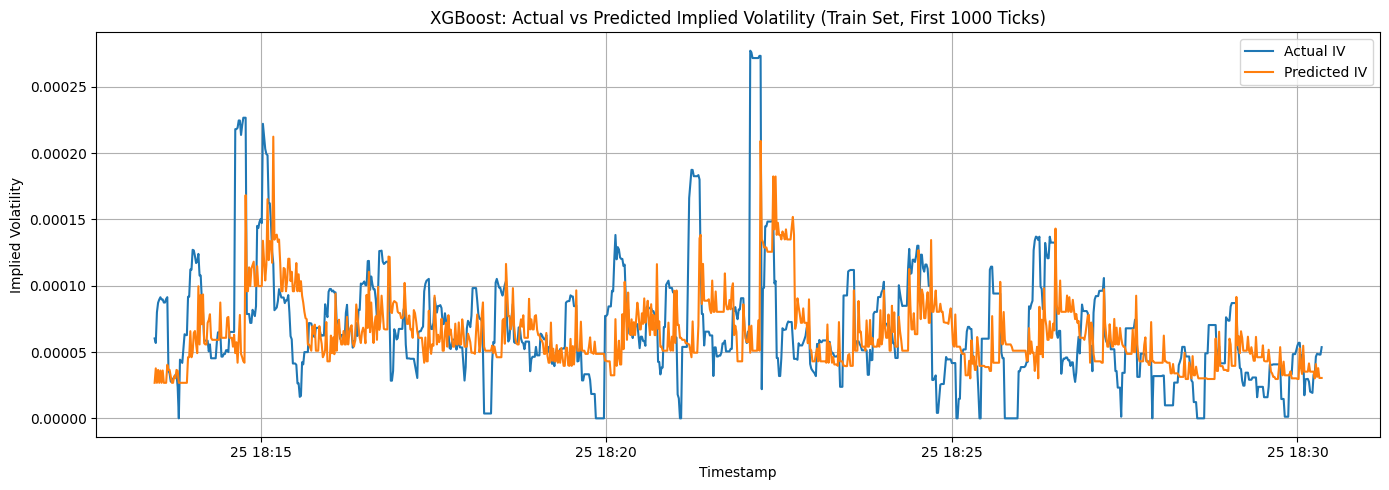

In [26]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Predict on training set
y_train_pred = model.predict(X_train)
# Pearson correlation
pearson = pearsonr(y_train, y_train_pred)[0]
# MAE
mae = mean_absolute_error(y_train, y_train_pred)
# Results
print("✅ Train Pearson Correlation:", round(pearson, 6))
print("✅ Train MAE:", round(mae, 8))

# Plot actual vs predicted IV for first 1000 points
plt.figure(figsize=(14, 5))
plt.plot(train_df['timestamp'][:1000], y_train[:1000], label='Actual IV')
plt.plot(train_df['timestamp'][:1000], y_train_pred[:1000], label='Predicted IV')
plt.title("XGBoost: Actual vs Predicted Implied Volatility (Train Set, First 1000 Ticks)")
plt.xlabel("Timestamp")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The plot compares actual vs predicted implied volatility for the first 1000 timestamps in training set.
MAE: Mean Absoluet error - measures the average absolute difference between actual and predicted values, quantifying the models prediction error 

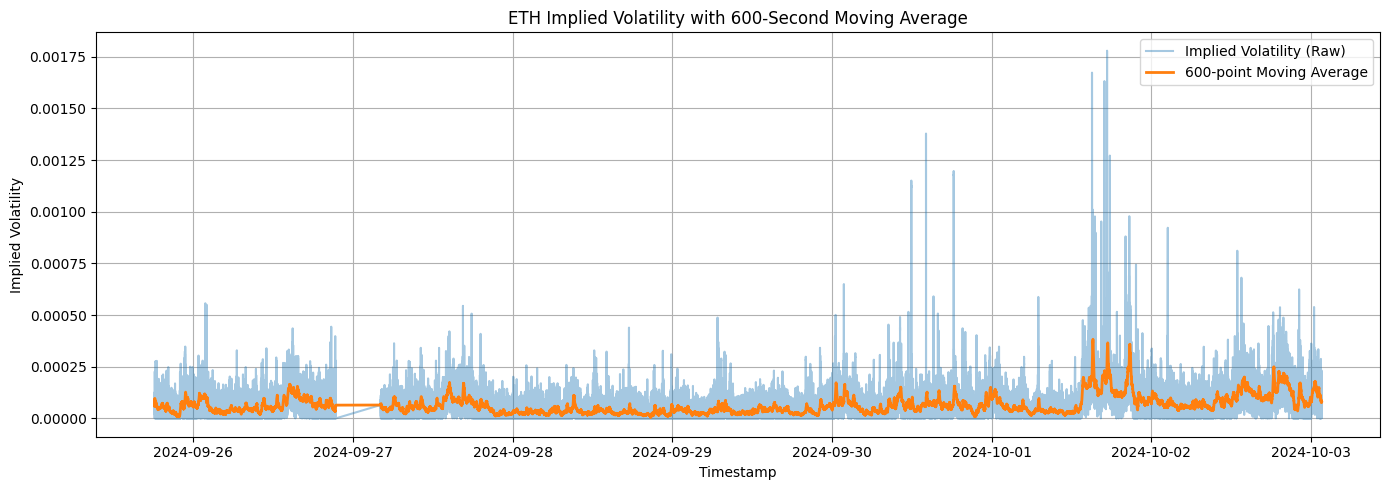

In [27]:
# Convert timestamp to datetime only if needed
if eth_train['timestamp'].dtype != 'datetime64[ns]':
    eth_train['timestamp'] = pd.to_datetime(eth_train['timestamp'])

# 600-point moving average (assuming 1s frequency ≈ 10 minutes)
eth_train['iv_ma_600'] = eth_train['label'].rolling(window=600, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(eth_train['timestamp'], eth_train['label'], label='Implied Volatility (Raw)', alpha=0.4)
plt.plot(eth_train['timestamp'], eth_train['iv_ma_600'], label='600-point Moving Average', linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("Implied Volatility")
plt.title("ETH Implied Volatility with 600-Second Moving Average")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SHAP Feature Importance

### SHapley Additive exPlanations: 
* a method to interpret machine learning models by quantifying the contribution of each feature to individual predictions.
* based on shapley values from cooperative game theory it fairly distributed the impact of each feature
* TreeExplainer: Specialized SHAP explainer optimized for tree-based models like XGBoost. Computes feature importance efficiently.
* shap_values: The contribution of each feature to the model’s predictions. Positive values push the prediction higher; negative values push it lower.
* SHAP allows us to understand which market features (spread, depth imbalance, log returns, realized volatility) drive the model’s predictions.

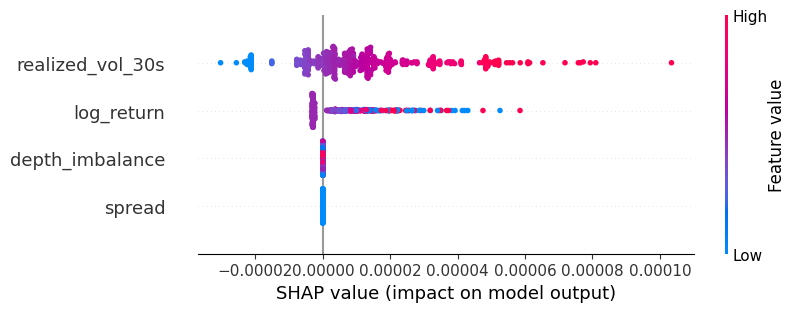

In [28]:
X_sample = X_train.iloc[:500].astype(np.float32)
# Use TreeExplainer for XGBoost
explainer = shap.Explainer(model, X_train, feature_names=X_train.columns.tolist())
shap_values = explainer(X_sample)
# Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=10)

## XGBoost Latency Benchmark

* measures the average time it takes for the XGBoost model to make a single prdiction which is crucial in high frequency trading or real time applications
* warm-up prediction - the firat call to model.predict ensures any lazy initialization inside XGBoost does not skew the timing
* converts the average latency into milliseconds for eaisier interpretation
* high frequency market data requires low-latency predictions
* measuring inference latency ensures the model can produce forecasts fast enough for real time decision making
* helps comapre differen models

In [29]:
runs = 100
sample = X_test.sample(1, random_state=42).values.astype(np.float32)
_ = model.predict(sample)
start = time.time()
for _ in range(runs):
    _ = model.predict(sample)
end = time.time()
avg_latency = (end - start) / runs
print(f"✅ Avg Inference Latency (XGBoost): {avg_latency * 1000:.2f} ms")

✅ Avg Inference Latency (XGBoost): 0.26 ms


# ARIMA forecasting - walk-forward on label

We are downsampling because or else it will take 40 hours to train based on the amoutn of data. We aggregate high frequency data into 10-second intervals to reudce noise and computational load.
Rolling ARIMA Forecasts:
For each time step after the initial training window, the model is refit on the last 10 minutes of data.
* predictions stores the forecasted implied volatility.
* actuals stores the true observed values for comparison.
* latencies measures computation time for each forecast.

ARIMA provides a classical time-series forecasting approach to predict short-term Ethereum implied volatility.

* rolling window ARIMA ensures the model adapts to recent market dynamics
* latency meausrement ensures feasibility for near real-time deployment in high-frequency trading envs

In [30]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import time
import pandas as pd

# Downsample to 10-second intervals
iv_series_ds = eth_train.set_index('timestamp')[['label']].resample('10S').mean().dropna()

train_window = 60      # 10min window
forecast_horizon = 3   # 30s ahead (3 x 10s steps)

n_points = len(iv_series_ds)
n_forecasts = n_points - train_window - forecast_horizon

# Pre-allocate arrays
actuals = np.zeros(n_forecasts)
predictions = np.zeros(n_forecasts)
latencies = np.zeros(n_forecasts)

for i in range(train_window, n_points - forecast_horizon):
    train_data = iv_series_ds.iloc[i - train_window:i]['label']
    actual_iv = iv_series_ds.iloc[i + forecast_horizon]['label']

    try:
        start_time = time.time()
        model = ARIMA(train_data, order=(5, 1, 0))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=forecast_horizon)[-1]
        latency = time.time() - start_time

        idx = i - train_window
        predictions[idx] = pred
        actuals[idx] = actual_iv
        latencies[idx] = latency
    except Exception as e:
        # Fill NaN if ARIMA fails
        idx = i - train_window
        predictions[idx] = np.nan
        actuals[idx] = actual_iv
        latencies[idx] = np.nan

# Convert results to a DataFrame
results = pd.DataFrame({
    'actual': actuals,
    'prediction': predictions,
    'latency': latencies
})

In [32]:
print("Total ARIMA predictions:", len(predictions))
print("Total ARIMA actuals:", len(actuals))

Total ARIMA predictions: 60541
Total ARIMA actuals: 60541


### ARIMA takes too much time to train on 6,30,000 about -40hours so we train on first 60,000 data points only

## ARIMA Evaluation

✅ ARIMA Pearson Correlation: 0.667533
✅ ARIMA MAE: 0.00002892
✅ ARIMA Avg Inference Latency: 126.57 ms


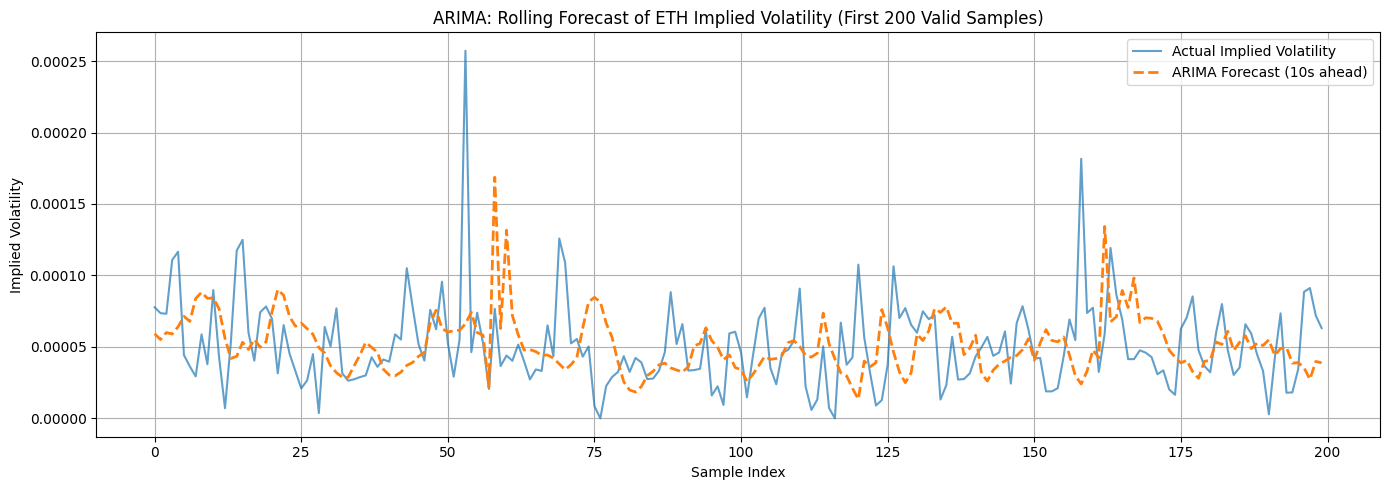

In [33]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Convert to arrays
actuals = np.array(actuals)
predictions = np.array(predictions)
latencies = np.array(latencies)

# Create mask to ignore NaNs
mask = ~np.isnan(predictions) & ~np.isnan(actuals)
actuals_clean = actuals[mask]
predictions_clean = predictions[mask]
latencies_clean = latencies[mask]

# Metrics
pearson_corr = pearsonr(actuals_clean, predictions_clean)[0]
mae = mean_absolute_error(actuals_clean, predictions_clean)
avg_latency = latencies_clean.mean()

# Print results
print(f"✅ ARIMA Pearson Correlation: {pearson_corr:.6f}")
print(f"✅ ARIMA MAE: {mae:.8f}")
print(f"✅ ARIMA Avg Inference Latency: {avg_latency * 1000:.2f} ms")

# Plot first 200 valid points
plt.figure(figsize=(14, 5))
plt.plot(actuals_clean[:200], label='Actual Implied Volatility', alpha=0.7)
plt.plot(predictions_clean[:200], label='ARIMA Forecast (10s ahead)', linestyle='--', linewidth=2)
plt.title("ARIMA: Rolling Forecast of ETH Implied Volatility (First 200 Valid Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare ARIMA with XGBoost

In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# ARIMA arrays 
arima_preds = np.array(predictions)      
actuals_arr = np.array(actuals)          
latencies_arima = np.array(latencies)   

#  XGBoost arrays 
xgb_preds = np.array(y_train_pred)       
y_train_arr = np.array(y_train)          
latencies_xgb = np.zeros_like(xgb_preds) 

#  Filter NaNs 
mask_arima = ~np.isnan(arima_preds) & ~np.isnan(actuals_arr)
actuals_arima = actuals_arr[mask_arima]
arima_preds_clean = arima_preds[mask_arima]
latencies_arima_clean = latencies_arima[mask_arima]

mask_xgb = ~np.isnan(xgb_preds) & ~np.isnan(y_train_arr)
actuals_xgb = y_train_arr[mask_xgb]
xgb_preds_clean = xgb_preds[mask_xgb]
latencies_xgb_clean = latencies_xgb[mask_xgb]

#  Metrics function 
def compute_metrics(y_true, y_pred, latencies):
    pearson = pearsonr(y_true, y_pred)[0]
    mae = mean_absolute_error(y_true, y_pred)
    avg_latency = np.mean(latencies)
    return pearson, mae, avg_latency

arima_metrics = compute_metrics(actuals_arima, arima_preds_clean, latencies_arima_clean)
xgb_metrics = compute_metrics(actuals_xgb, xgb_preds_clean, latencies_xgb_clean)

# Print metrics 
print("ARIMA Metrics:")
print(f"Pearson: {arima_metrics[0]:.6f}, MAE: {arima_metrics[1]:.8f}, Avg Latency: {arima_metrics[2]*1000:.2f} ms")
print("\nXGBoost Metrics:")
print(f"Pearson: {xgb_metrics[0]:.6f}, MAE: {xgb_metrics[1]:.8f}, Avg Latency: {xgb_metrics[2]*1000:.2f} ms")

ARIMA Metrics:
Pearson: 0.667533, MAE: 0.00002892, Avg Latency: 126.57 ms

XGBoost Metrics:
Pearson: 0.681652, MAE: 0.00002935, Avg Latency: 0.00 ms


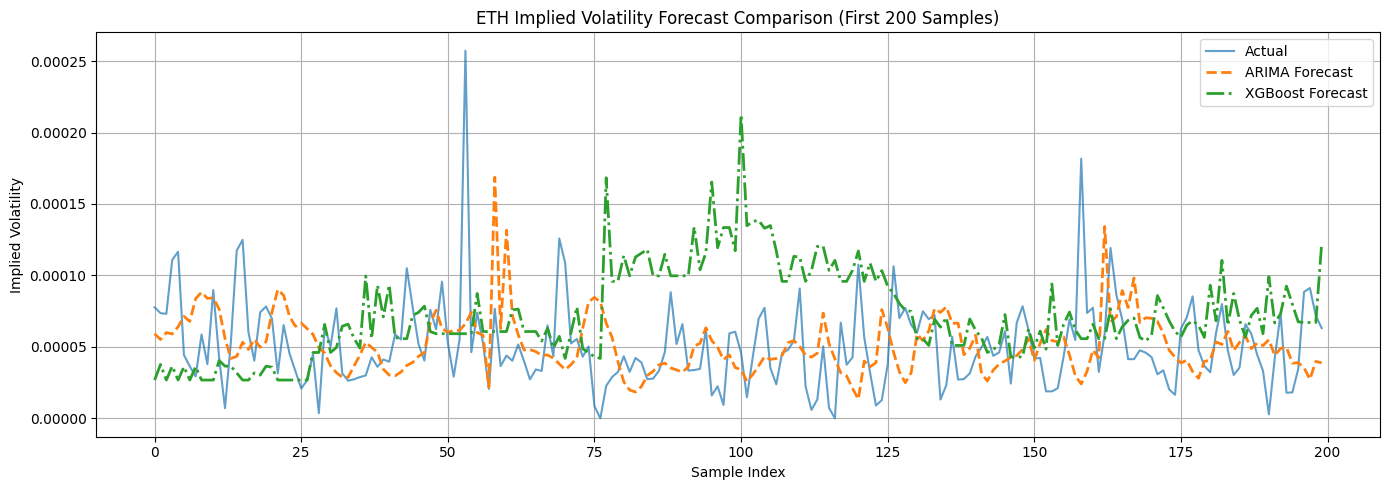

In [35]:
#  Plot comparison 
plt.figure(figsize=(14,5))
plt.plot(actuals_arima[:200], label="Actual", alpha=0.7)
plt.plot(arima_preds_clean[:200], label="ARIMA Forecast", linestyle='--', linewidth=2)
plt.plot(xgb_preds_clean[:200], label="XGBoost Forecast", linestyle='-.', linewidth=2)
plt.title("ETH Implied Volatility Forecast Comparison (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### We can see that XGB model works better than ARIMA model for forecasting ETH implied volatility from the Pearson Correlation

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

iv_series = pd.DataFrame({'label': actuals})
train_data = iv_series['label'].iloc[:1000]
model = ExponentialSmoothing(train_data, trend=None, seasonal=None)
model_fit = model.fit()
forecast = model_fit.forecast(10)

## Save submission file

In [39]:
print(len(timestamps_test))
print(len(xgb_preds_clean))

270548
536232


* No NaNs, all values are floats.

In [42]:
xgb_preds_clean = np.nan_to_num(y_pred_test, nan=0.0)
timestamps_int = np.arange(1, len(xgb_preds_clean) + 1)
assert len(xgb_preds_clean) == len(timestamps_int), "Prediction and timestamp lengths do not match!"
submission = pd.DataFrame({
    'timestamp': timestamps_int,
    'labels': xgb_preds_clean.astype(float)
})
submission.to_csv('submission.csv', index=False, float_format='%.8f')
print("Submission CSV head:")
print(submission.head())
print("\nCheck for NaNs or invalid values:")
print(submission.isna().sum())
print(submission.dtypes)


Submission CSV head:
   timestamp    labels
0          1  0.000027
1          2  0.000027
2          3  0.000041
3          4  0.000037
4          5  0.000041

Check for NaNs or invalid values:
timestamp    0
labels       0
dtype: int64
timestamp      int64
labels       float64
dtype: object


maybe ARIMA would have performed better if we could train on the entire data for 48 hours -  but thats a long time for predictions.